<a href="https://colab.research.google.com/github/FrancescoMorri/Language_Classification/blob/main/notebooks/Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np
from torch.utils.data import Dataset
import torch.nn as nn

sns.set()

PATH = "/content/drive/MyDrive/language/"

# Graphs of Loss and Accuracy

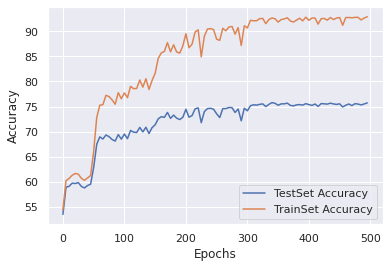

In [ ]:
data = np.loadtxt(PATH+"graphs/feed_forward_12chars_MSE_2.csv")
plt.plot(data[:,0], data[:,2], label="TestSet Accuracy")
plt.plot(data[:,0], data[:,3], label="TrainSet Accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
#plt.yscale("log")
plt.savefig(PATH+"graphs/MSE_12chars_best_2.png", bbox_inches='tight')
plt.show()

# Words analysis with model

## Loading the model

In [4]:
class Words_Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear1 = nn.Linear(312, 450)
        self.batch1 = nn.BatchNorm1d(450) 
        self.drop1 = nn.Dropout()
        self.linear2 = nn.Linear(450, 256)
        self.batch2 = nn.BatchNorm1d(256)
        self.drop2 = nn.Dropout()
        self.linear3 = nn.Linear(256, 64)
        #self.batch3 = nn.BatchNorm1d(64)
        #self.drop3 = nn.Dropout()
        self.linear4 = nn.Linear(64, 32)
        #self.drop4 = nn.Dropout()
        self.linear5 = nn.Linear(32, 1)

        self.act = nn.ReLU()

    def forward(self, x):
        out = self.linear1(x)
        out = self.drop1(out)
        out = self.batch1(out)
        out = self.act(out)

        out = self.linear2(out)
        out = self.drop2(out)
        out = self.batch2(out)
        out = self.act(out)

        out = self.linear3(out)
        #out = self.drop3(out)
        #out = self.batch3(out)
        out = self.act(out)

        out = self.linear4(out)
        #out = self.drop4(out)
        out = self.act(out)

        out = self.linear5(out)

        return out


In [5]:
net = Words_Net()
net.load_state_dict(torch.load(PATH+"net/feed_forward_12chars_MSE_2", map_location='cpu'))

<All keys matched successfully>

In [6]:
from torchsummary import summary
summary(net, (312,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 450]         140,850
           Dropout-2                  [-1, 450]               0
       BatchNorm1d-3                  [-1, 450]             900
              ReLU-4                  [-1, 450]               0
            Linear-5                  [-1, 256]         115,456
           Dropout-6                  [-1, 256]               0
       BatchNorm1d-7                  [-1, 256]             512
              ReLU-8                  [-1, 256]               0
            Linear-9                   [-1, 64]          16,448
             ReLU-10                   [-1, 64]               0
           Linear-11                   [-1, 32]           2,080
             ReLU-12                   [-1, 32]               0
           Linear-13                    [-1, 1]              33
Total params: 276,279
Trainable params:

## Load Dataset Class

In [7]:
from torch.utils.data import Dataset

class WordsDataset(Dataset):

    def __init__(self):
        self.samples = []

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.to_list()
        
        input = self.samples[idx][0]
        label = self.samples[idx][1]
        return input, label
    
    def __addsample__(self, spelling, lexicality, max_length=4):
        if (type(spelling) == type("str")):
            input = torch.tensor(word_to_vec(spelling, max_length=max_length), dtype=torch.float32)
            #check = [False if (i > 1. or i < 0.) else True for i in input]
            #if not all(check):
            #    print("PROBLEM")
            #    print(len(input), spelling)
            if (len(input) > max_length*26):
                print("PROBLEM")
                print(len(input), spelling)
            else:
                # here if it is torch is for the MSELoss, if it is an INT is for the crossentropy
                label = torch.tensor(label_maker(lexicality), dtype=torch.float32)
                #label = label_maker(lexicality)
                self.samples.append([input, label])
        else:
            print("Something Strange:", end='\t')
            print(spelling)

    def __removesample__(self, idx=0, value=None):
        '''
        If value is something, the element corresponding to that value is removed.
        Else the element at index idx is popped.
        '''
        if (value is not None):
            self.samples.remove(value)
        else:
            self.samples.pop(0)
        

In [8]:
trainloader = torch.load(PATH+"trainloader_12chars_MSE.pth")
testloader = torch.load(PATH+"testloader_12chars_MSE.pth")

We need a function to write the words that are encoded

In [9]:
def vec_to_word(vec):
    word = ""
    for i, a in enumerate(vec):
        if ( a == 1):
            idx = i%26
            char = chr(idx + 97)
            word += char
    return word

Here we prepare a list with tuple filled with the word *un-encoded*, the output of the model for that word and the correct label

In [10]:
data = []
net.eval()
with torch.no_grad():
    for i, tests in enumerate(testloader, 0):
        inputs, labels = tests
        outputs = net(inputs).squeeze()
        #print(outputs.shape, labels.shape, inputs.shape)
        for i,a in enumerate(inputs):
            out = outputs[i]
            lab = labels[i]
            word = vec_to_word(a)
            data.append((word, out, lab))


In [11]:
print("Example of entry in 'data':", end="\t")
print(data[0])

Example of entry in 'data':	('used', tensor(0.0677), tensor(0.))


Here we select the real words, that we will us to compute the mean Levenshtein distance for the non-words

In [12]:
real_w = []
for a in data:
    if (a[2] == 0):
        real_w.append(a[0])

This is what we need for the distance

In [13]:
!pip install python-Levenshtein
import Levenshtein as lev

     |████████████████████████████████| 51kB 2.3MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.0-cp36-cp36m-linux_x86_64.whl size=144796 sha256=fb3946c7a5aac501e3df04bf756efbedeabad1daebe231abddff601261abffbc
  Stored in directory: /root/.cache/pip/wheels/de/c2/93/660fd5f7559049268ad2dc6d81c4e39e9e36518766eaf7e342
Successfully built python-Levenshtein


In *full_data* we add to the non-words their mean Lev distance

In [14]:
full_data = []
for a in data:
    if (a[2] == 1):
        dist_t = 0
        for w in real_w:
            dist_t += lev.distance(a[0], w)
        dist_t /= len(real_w)

        full_a = a + (dist_t,)
        full_data.append(full_a)
    else:
        full_data.append(a)

In [16]:
print("Example of entry in 'full_data':")
print(full_data[0], full_data[1])

Example of entry in 'full_data':
('used', tensor(0.0677), tensor(0.)) ('scickeneanic', tensor(0.1340), tensor(1.), 10.267352920151547)


Now we can prepare some of this data for graphs

In [49]:
non_words = []
len_non = []
output_non = []
output_real = []
edit_dist = []
len_real = []
right_non_len = []
right_non_edit = []
wrong_non_edit = []
wrong_non_len = []
right_word_len = []
wrong_word_len = []
for a in full_data:
    if (a[2] == 1):
        non_words.append(a[0])
        output_non.append(float(a[1]))
        edit_dist.append(a[3])
        len_non.append(len(a[0]))
        if (round(float(a[1])) == 1):
            right_non_len.append(len(a[0]))
            right_non_edit.append(a[3])
        elif (round(float(a[1])) == 0):
            wrong_non_len.append(len(a[0]))
            wrong_non_edit.append(a[3])
    elif (a[2] == 0):
        output_real.append(float(a[1]))
        len_real.append(len(a[0]))
        if (round(float(a[1])) == 1):
            wrong_word_len.append(len(a[0]))
        elif (round(float(a[1])) == 0):
            right_word_len.append(len(a[0]))

Checking that everything worked out

In [26]:
print(real_w[0], output_real[0], len_real[0])

used 0.06765083968639374 4


## Various Graphs

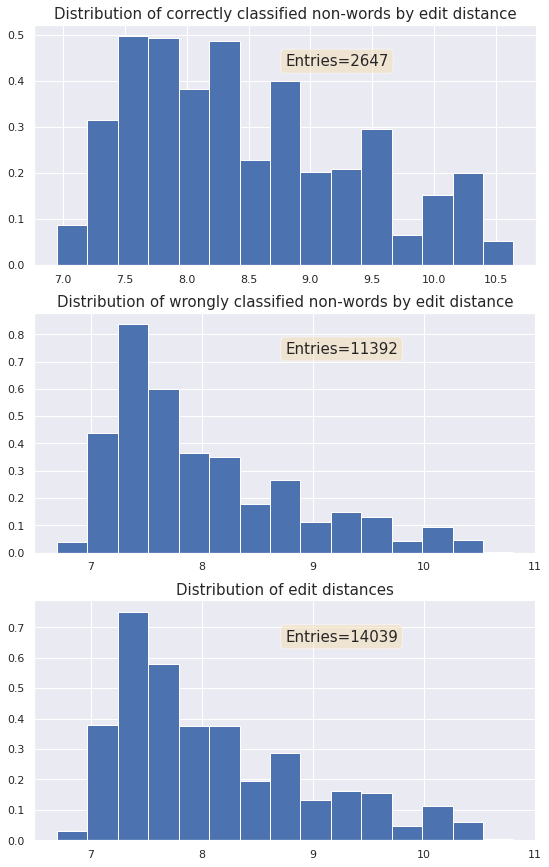

In [77]:
'''
plt.hist(right_non_len, bins=10)
plt.show()

plt.hist(wrong_non_len, bins=10)
plt.show()
'''
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig, ax = plt.subplots(3,1, figsize=(9,15))

ax[0].hist(right_non_edit, bins=15, density=True)
ax[0].set_title("Distribution of correctly classified non-words by edit distance", fontsize=15)
ax[0].text(0.5, 0.88, "Entries=%.d"%(len(right_non_edit)), transform=ax[0].transAxes, fontsize=15,
        verticalalignment='top', bbox=props)


ax[1].hist(wrong_non_edit, bins=15, density=True)
ax[1].set_title("Distribution of wrongly classified non-words by edit distance", fontsize=15)
ax[1].text(0.5, 0.88, "Entries=%.d"%(len(wrong_non_edit)), transform=ax[1].transAxes, fontsize=15,
        verticalalignment='top', bbox=props)


ax[2].hist(edit_dist, bins=15, density=True)
ax[2].set_title("Distribution of edit distances", fontsize=15)
ax[2].text(0.5, 0.88, "Entries=%.d"%(len(edit_dist)), transform=ax[2].transAxes, fontsize=15,
        verticalalignment='top', bbox=props)

fig.savefig(PATH+"graphs/nonwords_edit.png", bbox_inches='tight')
plt.show()

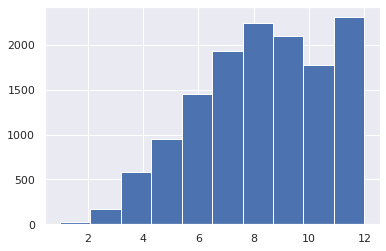

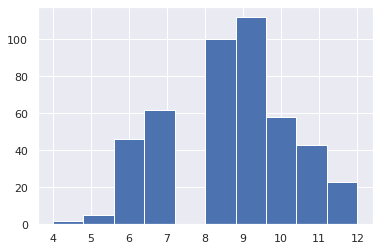

13538 451


In [64]:
plt.hist(right_word_len, bins=10)
plt.show()

plt.hist(wrong_word_len, bins=10)
plt.show()
print(len(right_word_len), len(wrong_word_len))

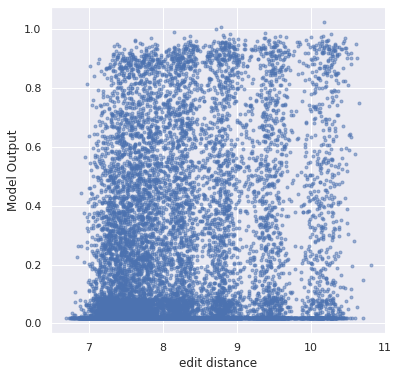

In [78]:
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(edit_dist, output_non, "o", alpha=0.5, markersize=3)
ax.set_xlabel("edit distance")
ax.set_ylabel("Model Output")
plt.savefig(PATH+"graphs/nonwords_edit_output.png", bbox_inches='tight')
plt.show()
